In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [136]:
df1 = pd.read_csv("E:\\RealEstate_Price_PredictionE2E\\Bengaluru_House_Data.csv") # Loading CSV file
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [137]:
df1.shape

(13320, 9)

In [138]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [139]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [140]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

Droping the collumns that are not required to build our model

In [141]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

In [142]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


Data preprocessing 
1st handling null values

In [143]:

df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [144]:
df2['location'].fillna(value=df2['location'].median, inplace=True)
df2['size'].fillna(value=df2['size'].mode, inplace=True)
df2['bath'].fillna(value=2, inplace=True)# mode of df2['bath]=2
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [145]:
def bhk_siz(a):
    for  i in a:
        try:
            k = int(i)
        except:
            pass
    return k
df2['size_bhk'] = [bhk_siz(str(i)) for i in df2['size']]
df2['size_bhk'].head()

0    2
1    4
2    3
3    3
4    2
Name: size_bhk, dtype: int64

Feature Engineering
Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

Explore total_sqft feature

In [146]:
df2['total_sqft']

0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13315    3453
13316    3600
13317    1141
13318    4689
13319     550
Name: total_sqft, Length: 13320, dtype: object

In [147]:

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,size_bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
224,Devanahalli,3 BHK,1520 - 1740,2.0,74.820,3
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases 
such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [148]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None


In [149]:
df2.total_sqft = df2.total_sqft.apply(convert_sqft_to_num)
df2 = df2[df2.total_sqft.notnull()]
df2.head(2)

,location,size,total_sqft,bath,price,size_bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [150]:
df2.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
size_bhk              4
Name: 30, dtype: object

Feature Engineering


Add new feature called price per square feet

In [151]:
df2['price_per_sqft'] = df2['price']*100000/df2['total_sqft']
df2.head()

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [152]:
df2_stats = df2['price_per_sqft'].describe()
df2_stats

count    1.327400e+04
mean     7.907501e+03
std      1.064296e+05
min      2.678298e+02
25%      4.266865e+03
50%      5.434306e+03
75%      7.311746e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [153]:
df2.to_csv("bhp.csv",index=False)

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [154]:
df2.location = df2.location.apply(lambda x: str(x).strip())
location_stats = df2['location'].value_counts(ascending=False)
location_stats

Whitefield                            539
Sarjapur  Road                        399
Electronic City                       304
Kanakpura Road                        271
Thanisandra                           236
                                     ... 
1Channasandra                           1
Hosahalli                               1
Vijayabank bank layout                  1
near Ramanashree California resort      1
Abshot Layout                           1
Name: location, Length: 1289, dtype: int64

In [155]:
location_stats.values.sum()

13274

In [156]:
len(location_stats[location_stats>10])

240

In [157]:
len(location_stats)

1289

In [158]:
len(location_stats[location_stats<=10])

1049

Dimensionality Reduction


Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [159]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Kalkere                               10
Thyagaraja Nagar                      10
BTM 1st Stage                         10
Basapura                              10
Dodsworth Layout                      10
                                      ..
1Channasandra                          1
Hosahalli                              1
Vijayabank bank layout                 1
near Ramanashree California resort     1
Abshot Layout                          1
Name: location, Length: 1049, dtype: int64

In [160]:
len(df2.location.unique())

1289

In [161]:
df2.location = df2.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df2.location.unique())

241

In [162]:
df2.head(10)

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


Outlier Removal Using Business Logic

Lets say normally square ft per bedroom is 300. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [163]:
df2[df2['total_sqft']/df2['size_bhk']<300].head()

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [164]:
df2.shape

(13274, 7)

In [165]:
df3 = df2[~(df2['total_sqft']/df2['size_bhk']<300)]
df3.shape

(12544, 7)

Outlier Removal Using Standard Deviation and Mean

In [166]:
df3.price_per_sqft.describe()

count     12544.000000
mean       6314.356885
std        4178.595720
min         267.829813
25%        4210.526316
50%        5295.544522
75%        6923.076923
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [167]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df3 = remove_pps_outliers(df3)
df3.shape

(10316, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

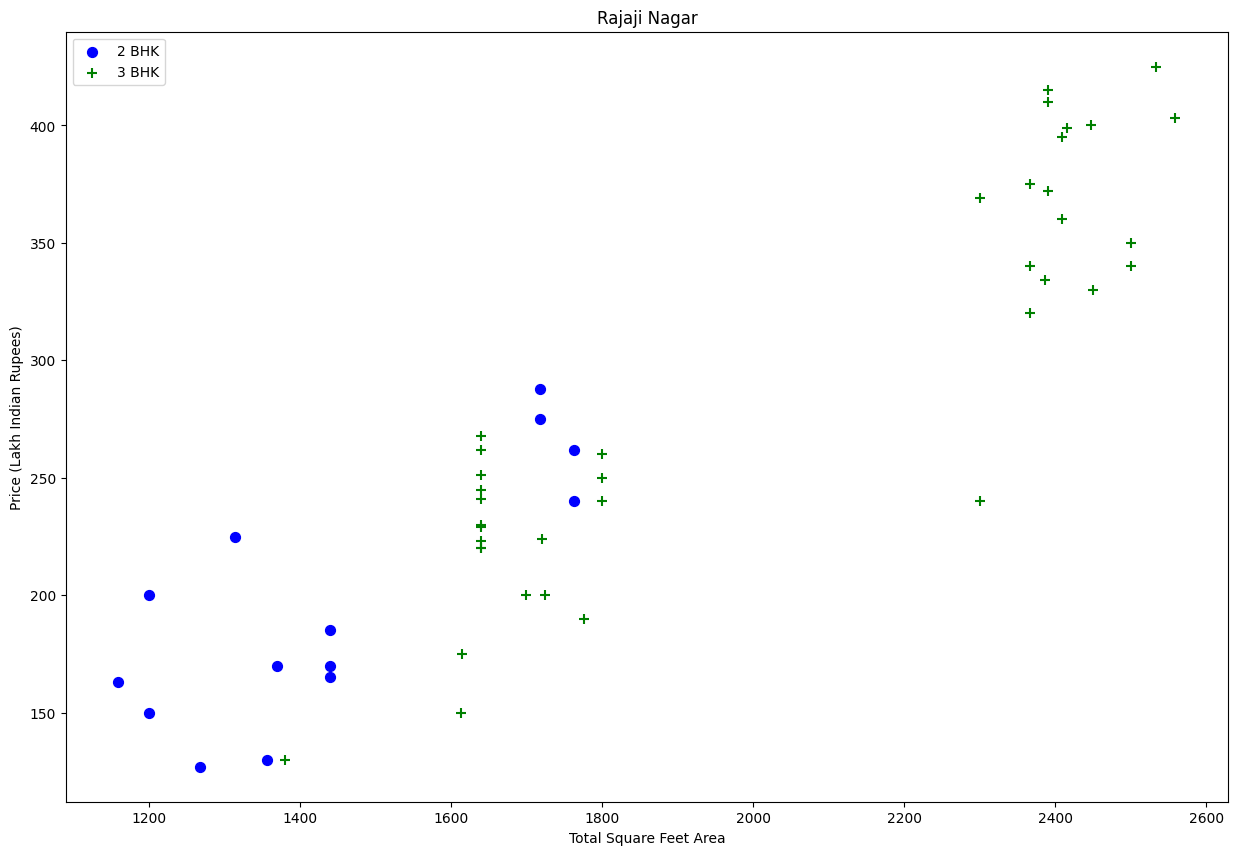

In [168]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.size_bhk==2)]
    bhk3 = df[(df.location==location) & (df.size_bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df3,"Rajaji Nagar")

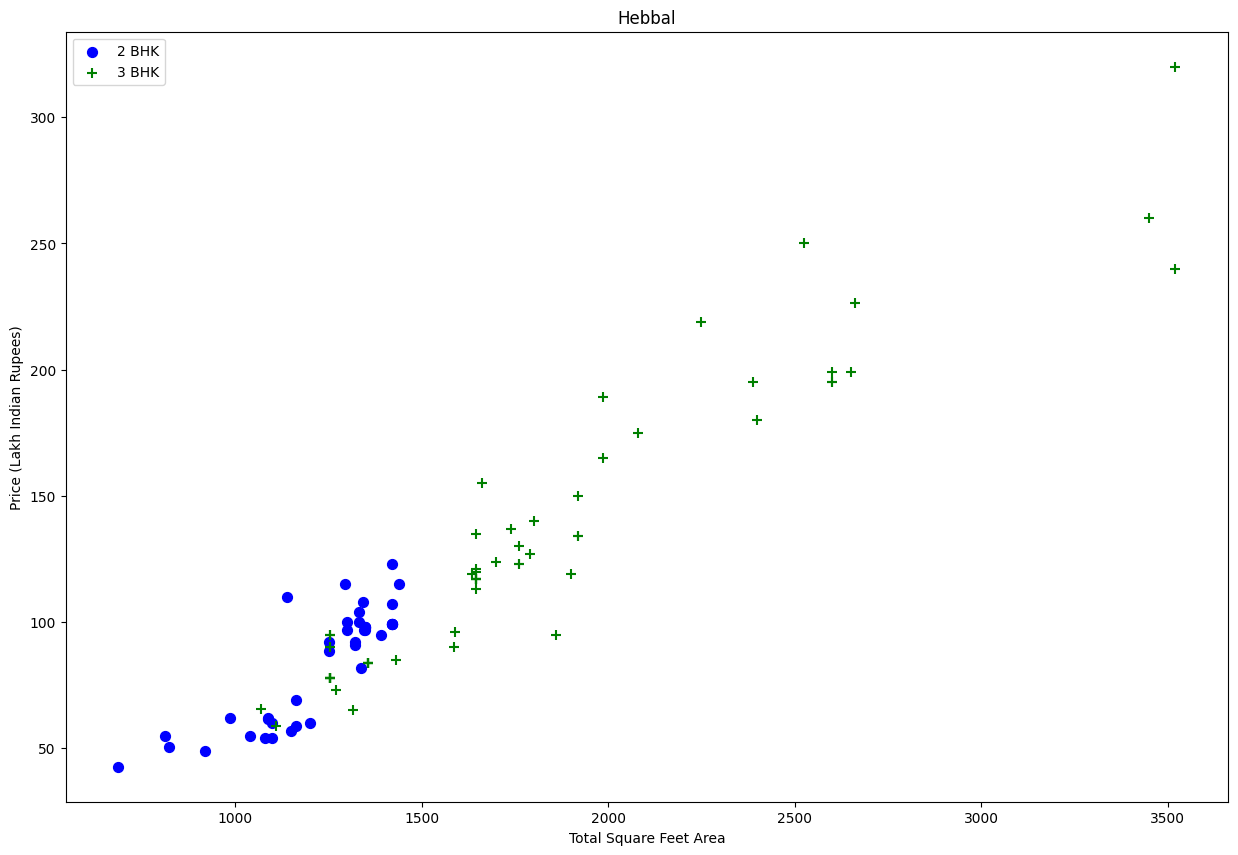

In [169]:
plot_scatter_chart(df3,"Hebbal")


We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.



{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}


Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [170]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('size_bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('size_bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df3 = remove_bhk_outliers(df3)
# df8 = df7.copy()
df3.shape

(7243, 7)

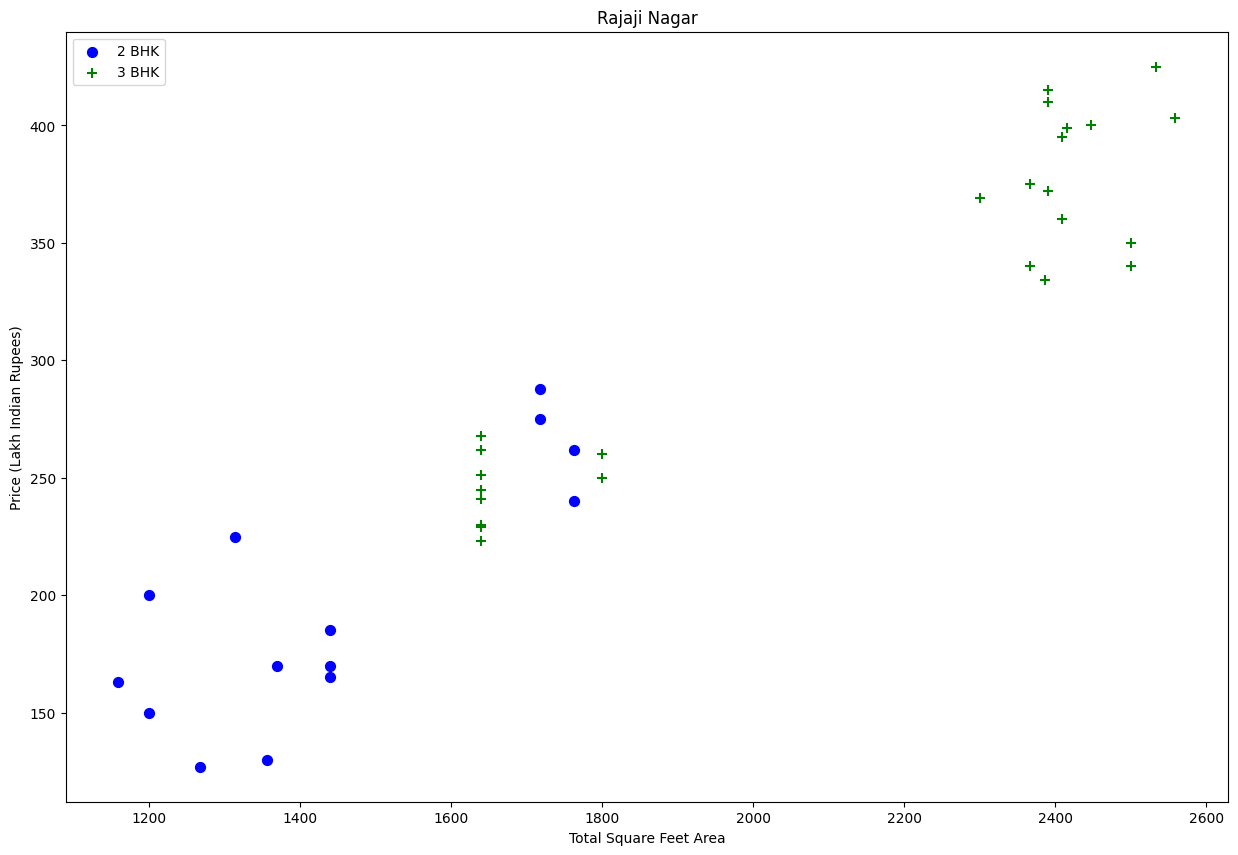

In [171]:
plot_scatter_chart(df3,"Rajaji Nagar")

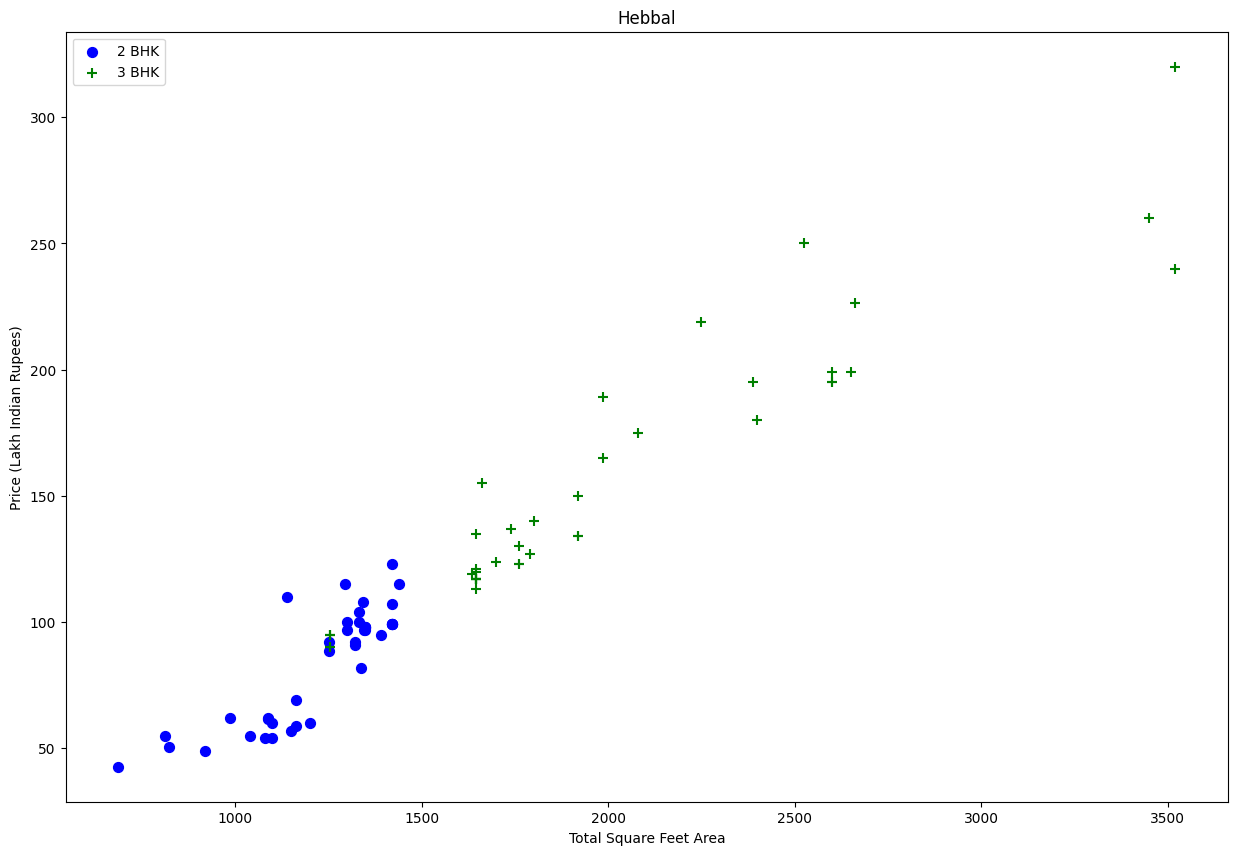

In [172]:
plot_scatter_chart(df3,"Hebbal")

Text(0, 0.5, 'Count')

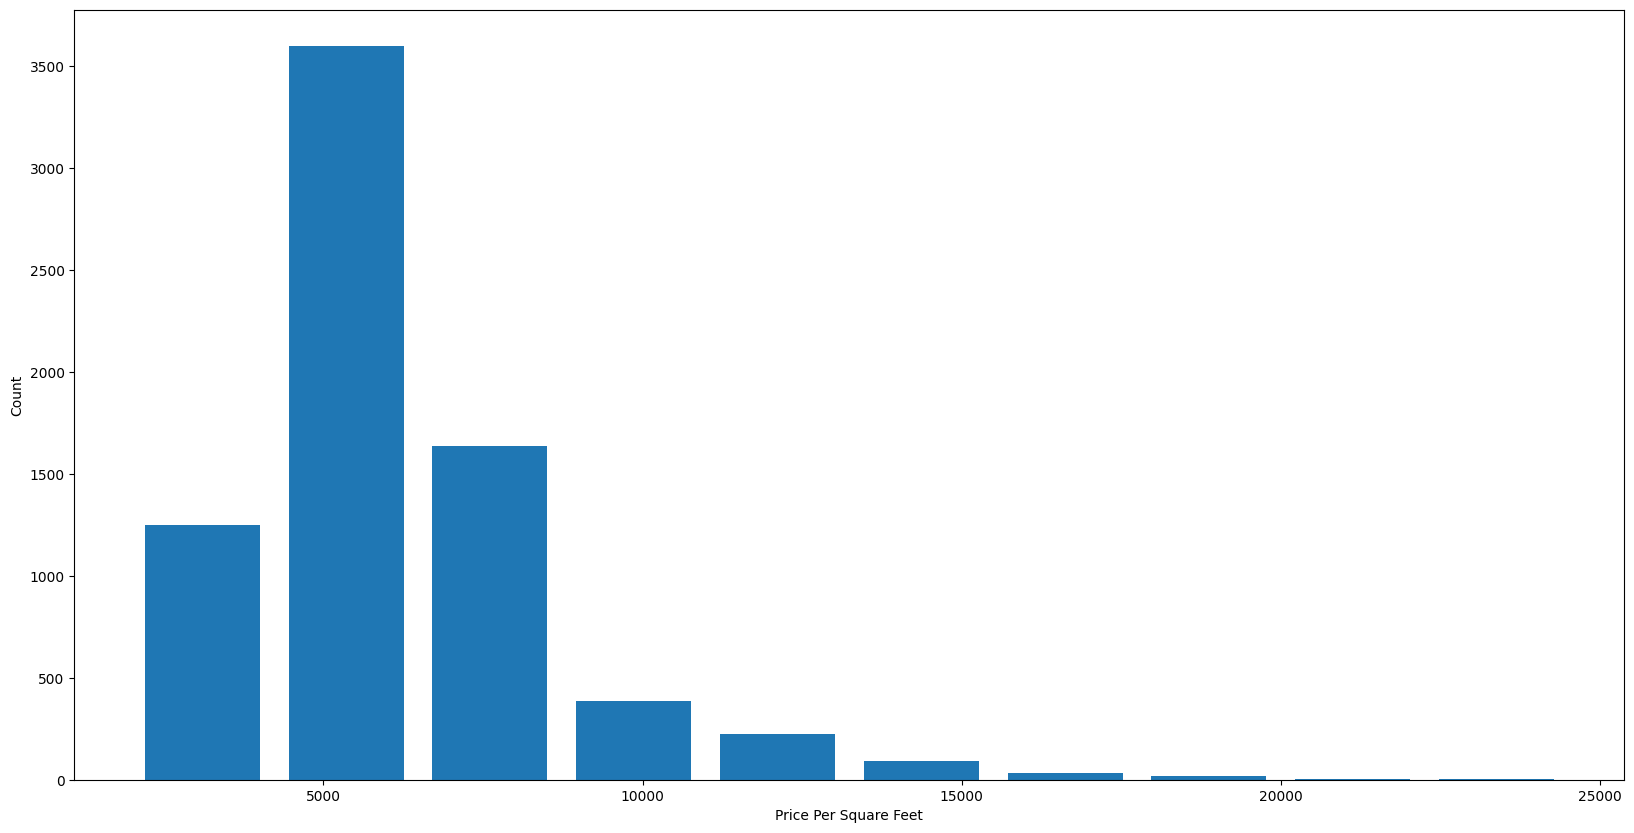

In [173]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df3.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Outlier Removal Using Bathrooms Feature

In [174]:
df3['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 10., 12., 15.])

Text(0, 0.5, 'Count')

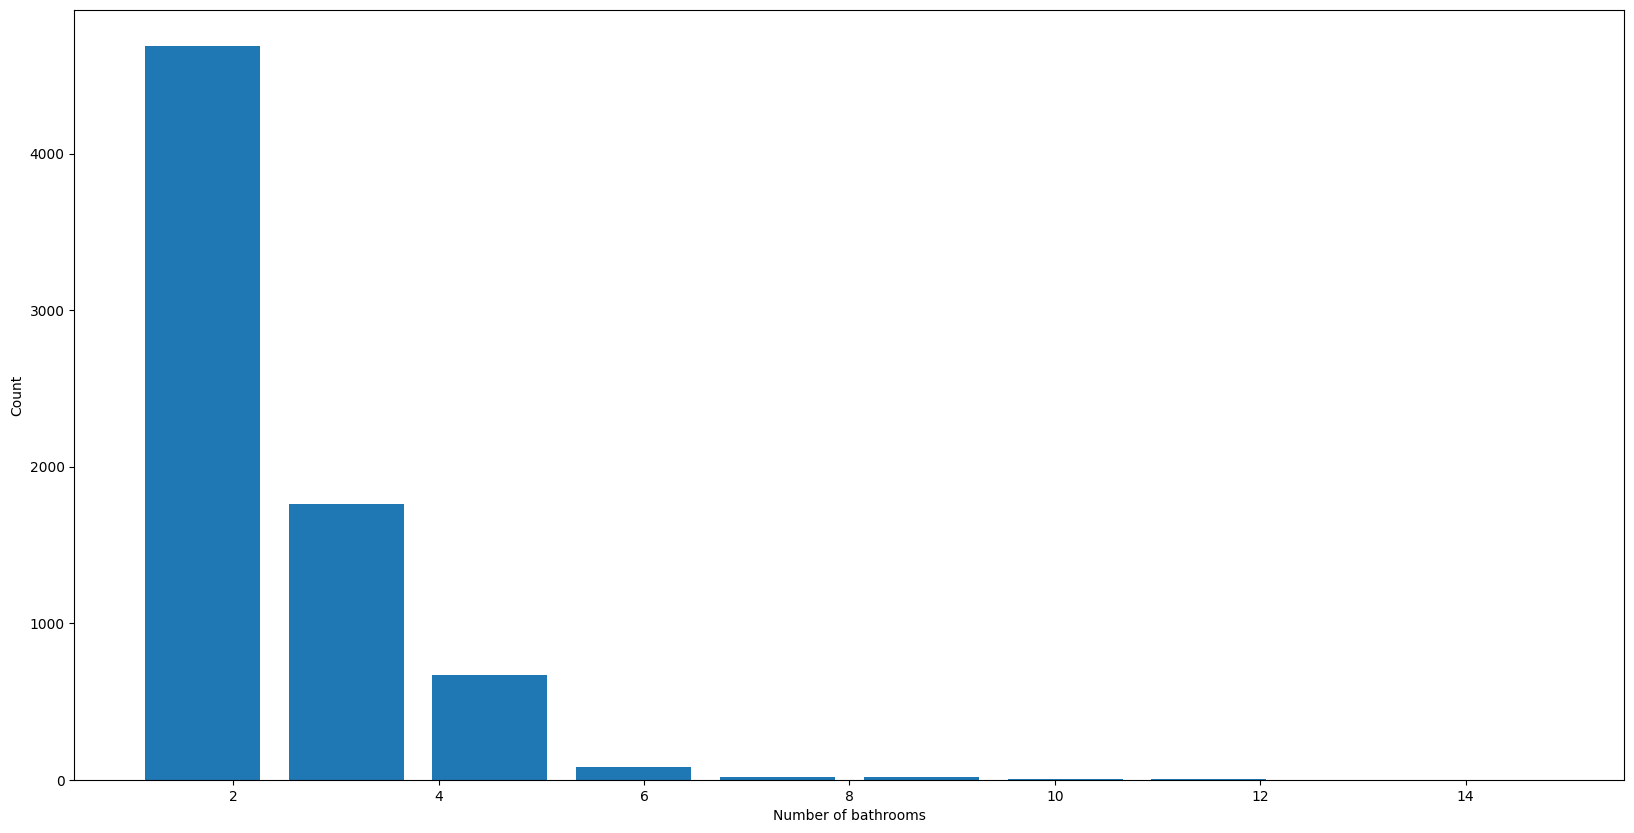

In [175]:
plt.hist(df3.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [176]:
df3[df3.bath>10]

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
5322,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,0,4000.0
8551,other,10 BHK,12000.0,12.0,525.0,0,4375.0
8870,other,14 BHK,1250.0,15.0,125.0,4,10000.0


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [177]:
df3[df3.bath>df3.size_bhk+2]

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5173,Munnekollal,10 Bedroom,7200.0,10.0,200.0,0,2777.777778
5283,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
5322,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,0,4000.000000
6768,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8086,other,11 BHK,5000.0,9.0,360.0,1,7200.000000
8317,other,10 Bedroom,750.0,10.0,90.0,0,12000.000000
8476,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
8551,other,10 BHK,12000.0,12.0,525.0,0,4375.000000
8695,other,11 Bedroom,1200.0,6.0,150.0,1,12500.000000


if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [178]:
df3[df3.bath<df3.size_bhk+2]
df3.shape

(7243, 7)

In [179]:
df3.head(2)

,location,size,total_sqft,bath,price,size_bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [180]:
df4 = df3.drop(['size','price_per_sqft'],axis='columns')
df4.head(3)

,location,total_sqft,bath,price,size_bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


Use One Hot Encoding For Location

In [181]:
dummies = pd.get_dummies(df4.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
df5 = pd.concat([df4,dummies.drop('other',axis='columns')],axis='columns')
df5.head()

,location,total_sqft,bath,price,size_bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
df6 = df5.drop('location',axis='columns')
df6.head(2)

,total_sqft,bath,price,size_bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Time to Build a Model...

In [184]:
df6.shape

(7243, 244)

In [185]:
X = df6.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,size_bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
X.shape

(7243, 243)

In [187]:
y = df6.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [188]:
len(y)

7243

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

Choose Machine Learning algorithm using GridSearchCV

In [199]:

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X': [True,False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "e:\Rea

,model,best_score,best_params
0,linear_regression,0.864370,{'copy_X': True}
1,lasso,0.728055,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.690204,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

In [190]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8065079697884779

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [191]:

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.8818513 , 0.85721758, 0.86076198, 0.88036154, 0.8416586 ])

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

Test the model for few properties

In [200]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [201]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


84.89674583941985

In [202]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


88.14465141564317

In [203]:
predict_price('Indira Nagar',1000, 2, 2)

e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


182.88641087661637

In [204]:
predict_price('Indira Nagar',1000, 3, 3)

e:\RealEstate_Price_PredictionE2E\.venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


186.13431645283964

Export the tested model to a pickle file

In [205]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

Export location and column information to a file that will be useful later on in our prediction application

In [206]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))